In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


In [2]:
batch_size = 8   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
nr_cats = len(categories)
nr_annotations = len(anns)

cat_names = []

for cat_it in categories:
    cat_names.append(cat_it['name'])

In [5]:
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            # anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [8]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Soft Voting

In [9]:
import segmentation_models_pytorch as smp
model = []
model.append(smp.DeepLabV3Plus(
    encoder_name="se_resnext101_32x4d", 
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=11,                     
))
model.append(smp.FPN(
    encoder_name="se_resnext101_32x4d", 
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=11,                     
))
model.append(smp.UnetPlusPlus(
    encoder_name="se_resnext101_32x4d", 
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=11,                     
))
model.append(smp.UnetPlusPlus(
    encoder_name="efficientnet-b7", 
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=11,                     
))

model_path = ['./saved/se_resnext101_32x4d_deeplabv3+_editloader_20epoch_best_model.pt','./saved/se_resnext101_FPN_editloader_best_model.pt','./saved/se_resnext101_unetPP_best_model.pt','./saved/effi7_unetPP_best_model.pt']
model_path = ['/opt/ml/segmentation/mmsegmentation/work_dirs/epoch_100_kfold_0_.pth','/opt/ml/segmentation/mmsegmentation/work_dirs/epoch_100_4.pth','/opt/ml/segmentation/mmsegmentation/work_dirs/epoch_100_kfold_1.pth','/opt/ml/segmentation/mmsegmentation/work_dirs/epoch_120_kfold_2.pth','/opt/ml/segmentation/mmsegmentation/work_dirs/epoch_120_kfold_3.pth']

for i, path in enumerate(model_path):
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint.state_dict()
    model[i].load_state_dict(state_dict)
    model[i] = model[i].to(device)

AttributeError: 'dict' object has no attribute 'state_dict'

In [50]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    for i in range(len(model)):
        model[i].eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = torch.zeros((len(imgs), 11, 512, 512)).to(device)
            for i in range(len(model)):
                outs += model[i](torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

In [51]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/4models_ensemble_1027.csv", index=False)

  0%|          | 0/103 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 103/103 [09:18<00:00,  4.54s/it]


End prediction.


## Hard Voting

In [18]:
folder_name = './submission/kfold_submission/'
# path_list=['effi7_unetPP_1019.csv','se_resnext101_32x4d_deeplabv3+_editloader_20epoch_1026.csv','se_resnext101_unetPP_1021.csv','tu-hrnet_w48_unetPP_40epoch_1025.csv','4models_ensemble_1027.csv']
path_list = os.listdir(folder_name)
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

In [19]:
path_list

['se_resnext101_DeepLabV3+_686.csv',
 'se_resnext101_Unet++_655.csv',
 'regnety_320_DeepLabV3+_669.csv',
 'senet154_DeepLabV3+_671.csv',
 'upernet_swin_756.csv']

In [20]:
# 너무 오래 걸림 190장 하는데 14분 걸렸음
# voting이 동일한 경우 앞의 수가 선택된다는 점이 문제->이건 확률상 이로울지도 (weight주거나 여러결과를 하면 문제 어느정도 해소 되겠지만 시간이 역시나 많이 걸림)
for img_num in range(819):
    sum_sub = np.zeros((11,256,256))
    for path in path_list:
        pred = pd.read_csv(folder_name + path, index_col=None)['PredictionString'][img_num].split(' ')
        file_name = pd.read_csv(folder_name + path, index_col=None)['image_id'][img_num]
        pred = list(map(int, pred))
        for n,i in enumerate(pred):
            if i!=0:
                row = n//256
                col = n%256
                sum_sub[i,row,col]+=1
    sum_sub = np.argmax(sum_sub, axis=0) # 가장 선택 많이 받은 채널 256*256으로
    sum_sub = np.reshape(sum_sub,256*256) # flatten
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in sum_sub.tolist())},ignore_index=True)

In [21]:
submission.to_csv("./submission/5models_hardvoting_1029.csv", index=False)

In [288]:
from scipy import stats
for img_num in range(819):
    sum_sub = []
    for path in path_list:
        pred = pd.read_csv(folder_name + path, index_col=None)['PredictionString'][img_num].split(' ')
        # pred = np.fromstring(pd.read_csv(path, index_col=None)['PredictionString'][img_num], dtype=np.uint8)
        file_name = pd.read_csv(folder_name + path, index_col=None)['image_id'][img_num]
        pred = list(map(int, pred))
        sum_sub.append(pred)
    np_sum_sub = np.array(sum_sub)
    result = stats.mode(np_sum_sub, axis=0)[0]
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in result[0])},ignore_index=True)
    if img_num==4:
        break

In [182]:
t = [int(i) for i in submission.loc[0,'PredictionString'].split(' ')]

In [184]:
tt= np.reshape(np.array(t),(256,256))

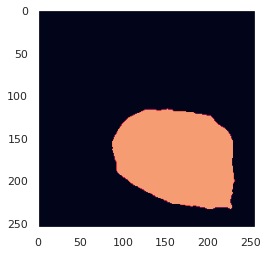

In [186]:
plt.imshow(tt, vmin=0, vmax=10)

In [176]:
#위의 방법이 0.5s라 채택, 하지만 알아두면 좋을듯 함!
mat = np.reshape(sub1,(256,256)) # flatten되어있는 pred값을 256*256으로
result = np.arange(11) == mat[..., None] # 256,256,1로 차원을 바꿔준 뒤([[[0],[0],....[0]]]) 한 개씩 꺼내 [0,1,2,3,4,5,6,7,8,9,10]에 일치하는 것을 찾아 [True,False,False...로]
answer=result.transpose(2,0,1).astype(np.uint8) # 256*256*11로 되어있으니 11*256*256으로 Transpose해주고 True,False로 되어있는걸 int인 1,0으로 바꿔 줌

In [ ]:
# 설명 2차원 
[[[ ]]] 1,256, 256

classification
label = [7, 3, 1, 2]<- shape 60000 -> shape 60000,1
[[7], 
[3], 
[1], 
[2]]

60000, 11

np.zeros((data num, 11))[label] = 1

0 0 0 0 0 0 0 1 0 0 0 0
...


array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [ ]:
#설명 3차원
class value
0 0 0 0 0
0 0 0 0 0
0 0 1 1 0
0 0 1 1 0
0 0 0 0 0

[[0, 0, 0, 0, 0]]
[[[0], [0], [0], [0] ...]] <- mat[..., None] 256, 256 ,1

# 0ch
1 1 1 1 1
1 1 1 1 1
1 1 0 0 1
1 1 0 0 1
1 1 1 1 1

# 1ch
0 0 0 0 0
0 0 0 0 0
0 0 1 1 0
0 0 1 1 0
0 0 0 0 0

2, 5, 5

[1, 0] <- class length np.arange(class len) -> [0, 1,2,3,4,5] == [0] -> True, False , False, False, False, False -> npuint8 -> 1, 0 ,0,0,0,0
[1, 0]
.
.
256 256 11
1 0 0 0 0
1 0 0 0 0 


## Submission visualization

In [23]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import webcolors

In [24]:
data_root_dir = '../input/data'

left_csv = './submission/5models_hardvoting_1029.csv'
# right_csv = './seg682.csv'
start_sample_num = 800
num_examples = 19

In [25]:
left_df = pd.read_csv(left_csv)
left_pred_strs = left_df["PredictionString"]
left_image_ids = left_df['image_id']
left_pred_array_list = []
for pred_str in left_pred_strs:
    flatten_pred_ints = [int(pred) for pred in pred_str.split(' ')]
    pred_array = np.asarray(flatten_pred_ints, dtype=np.uint8).reshape(256, 256)
    left_pred_array_list.append(pred_array)

# right_df = pd.read_csv(right_csv)
# right_pred_strs = right_df["PredictionString"]
# right_image_ids = right_df['image_id']
# right_pred_array_list = []
# for pred_str in right_pred_strs:
#     flatten_pred_ints = [int(pred) for pred in pred_str.split(' ')]
#     pred_array = np.asarray(flatten_pred_ints, dtype=np.uint8).reshape(256, 256)
#     right_pred_array_list.append(pred_array)

In [26]:
class_colormap = pd.read_csv("class_dict.csv")
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                         edgecolor=webcolors.rgb_to_hex(rgb), 
                         label=category) for category, rgb in category_and_rgb]

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

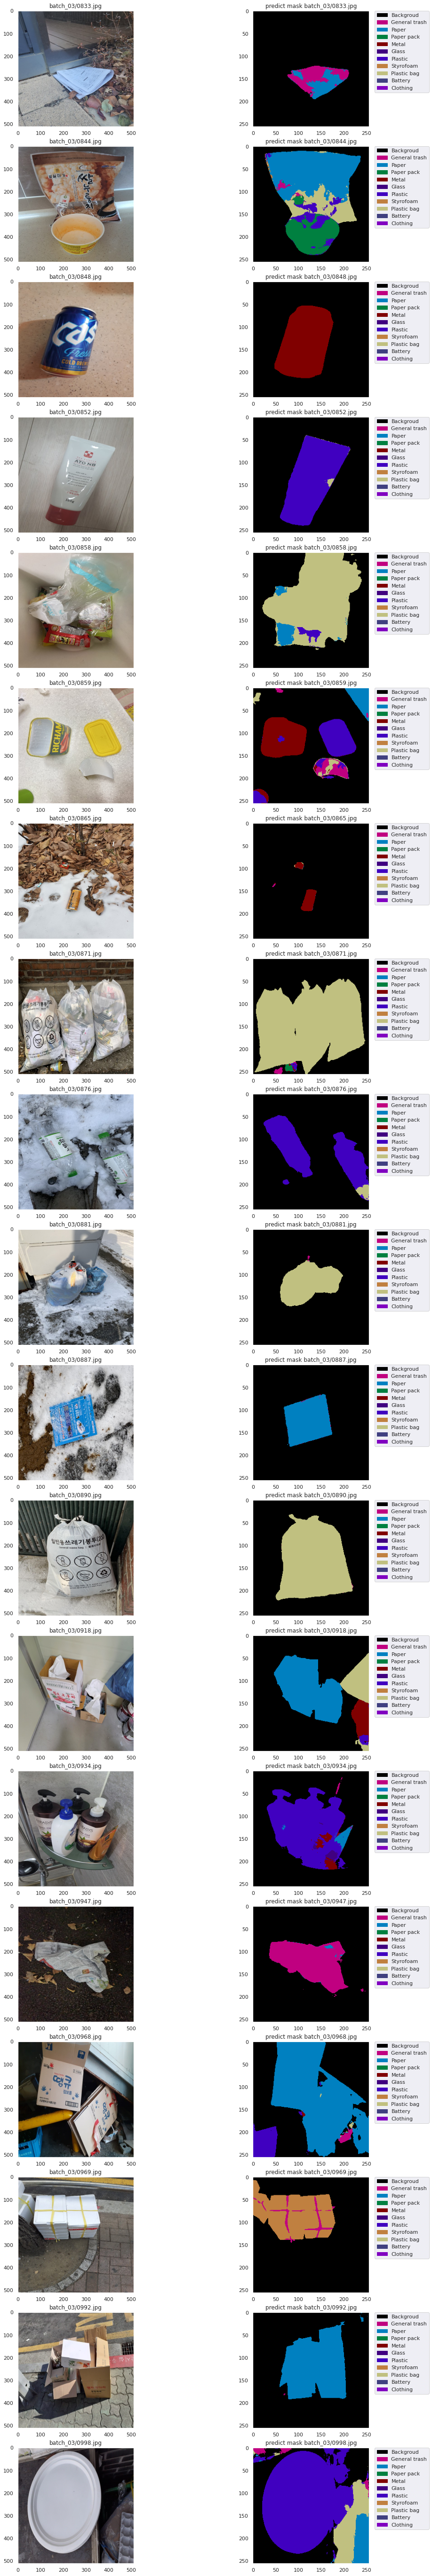

In [29]:
fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(14, 4*num_examples), constrained_layout=True)

for row_num, sample_num in enumerate(range(start_sample_num, start_sample_num+num_examples)):
    # org
    image_load = cv2.imread(data_root_dir + '/' + left_image_ids[sample_num])
    ax[row_num][0].imshow(cv2.cvtColor(image_load, cv2.COLOR_BGR2RGB))
    ax[row_num][0].set_title(f"{left_image_ids[sample_num]}")
    # left
    ax[row_num][1].imshow(label_to_color_image(left_pred_array_list[sample_num]))
    ax[row_num][1].set_title(f"predict mask {left_image_ids[sample_num]}")
    ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    # right
    # ax[row_num][2].imshow(label_to_color_image(right_pred_array_list[sample_num]))
    # ax[row_num][2].set_title(f"{right_image_ids[sample_num]}")
    # ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    # ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()